In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import toeplitz, circulant
from scipy.stats import linregress as linreg

import scipy.fftpack as fft

import sympy as smp

from pytex import *

from scipy.integrate import quadrature as quad

In [2]:
matplotlib.rcParams.update({'font.size': 14})

# Problem 1

In [3]:
def p_func(x):
    return 2*np.tan(x)

def q_func(x):
    try:
        n = len(x)
    except TypeError:
        n = 0
    return np.zeros(n)

def r_func(x):
    try:
        n = len(x)
    except TypeError:
        n = 0
    return 2*np.ones(n)

def exact(x):
    return (x-1)*np.tan(x)

In [4]:
def fd2tpbvp(a, b, aplha, beta, p_func, q_func, r_func, m):
    h = (b-a)/(m+1)
    xs = np.linspace(a, b, m+2, endpoint=True)
    inner_xs = xs[1:-1]
    D2 = 1/h**2 * sp.diags([ [-2]*m, [1]*(m-1), [1]*(m-1) ], offsets=[0,1,-1], format='csr')
    D1 = 1/(2*h) * sp.diags([ [1]*(m-1), [-1]*(m-1) ], offsets=[1,-1], format='csr')
    P = sp.diags(p_func(inner_xs))
    Q = sp.diags(q_func(inner_xs))
    r = r_func(inner_xs)

    A = D2-P@D1-Q
    rhs = r
    rhs[0] -= alpha/h*(1/h + p_func(a)/2)
    rhs[-1] -= beta/h*(1/h - p_func(b)/2)

    u = spla.spsolve(A, rhs)
    return np.block([alpha, u, beta]), xs

In [5]:
a, b = 0, 1
alpha, beta = 0, 0

num_ms = 5
ms = [10*2**i for i in range(num_ms)]

hs = [1/(m+1) for m in ms]

errors = []
for m in ms:
    u, xs = fd2tpbvp(a, b, alpha, beta, p_func, q_func, r_func, m)
    err = la.norm(u - exact(xs))/la.norm(exact(xs))
    errors.append(err)

#plt.plot(xs, u_all, 'bo')
#plt.plot(xs, exact(xs), 'r-')

In [6]:
ms

[10, 20, 40, 80, 160]

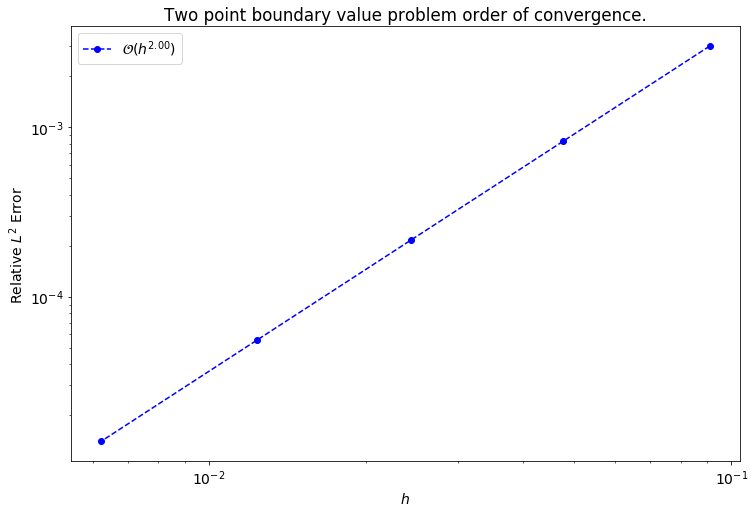

In [7]:
order = linreg(np.log(hs), np.log(errors))[0]

plt.figure(figsize=(12,8))
plt.loglog(hs, errors, 'bo--')
plt.legend(['$\mathcal{O}(h^{%.2f})$'%order])
#plt.xticks(hs[::2], ['$i=%d$'%i for i in range(num_ms)])
plt.xlabel('$h$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Two point boundary value problem order of convergence.')
plt.show()

# Problem 2

In [8]:
def cheb_diff_mat(n, m, a, b):
    thetas = np.linspace(0, np.pi, n, endpoint=True)
    T = np.repeat(.5*thetas.reshape((n,1)), n, axis=1)
    DX = 2 * np.sin(T.T + T) * np.sin(T.T - T)
    DX[n//2:] = -np.rot90(DX[:(n+1)//2], 2)
    DX[np.diag_indices(n)] = np.ones(n)
    C = (-1.0) ** np.add.outer(np.arange(n), np.arange(n))
    C[0]    *= 2
    C[-1]   *= 2
    C[:,0]  *= .5
    C[:,-1] *= .5
    Z = 1/DX
    Z[np.diag_indices(n)] = np.zeros(n)
    D = np.eye(n)
    DM = np.zeros((m,n,n))
    scale_factor = 1
    for i in range(m):
        D = (i+1)*Z*(C * np.multiply.outer(np.diag(D), np.ones(n)) - D)
        D[np.diag_indices(n)] = -D @ np.ones(n)
        scale_factor *= 2/(b-a)
        DM[i] = scale_factor * D[::-1,::-1] #account for flipping the points
    xs = -np.cos(thetas) #standard Chebyshev points
    xs = (xs+1) * (b-a)/2 + a #shifted
    return xs, DM

First Derivative Error: 	2.12549e-14
Second Derivative Error: 	9.26712e-12


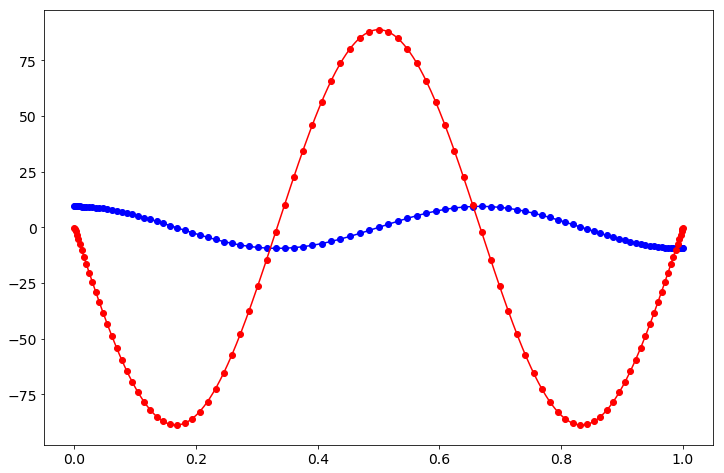

In [9]:
# Testing
n, m = 101, 2
a, b = 0, 1

def foo(x):
    return np.sin(3*np.pi*x)
def dfoo(x):
    return 3*np.pi * np.cos(3*np.pi*x)
def d2foo(x):
    return (3*np.pi)**2 * -np.sin(3*np.pi*x)

xs, D = cheb_diff_mat(n,m, a, b)
xs = xs[1:-1]
D = D[:,1:-1,1:-1]

zs = np.linspace(a,b, 1000)

err = la.norm(D[0]@foo(xs) - dfoo(xs))/la.norm(dfoo(xs))
print('First Derivative Error: \t%g' % err)
err = la.norm(D[1]@foo(xs) - d2foo(xs))/la.norm(d2foo(xs))
print('Second Derivative Error: \t%g' % err)

plt.figure(figsize=(12,8))
plt.plot(zs, dfoo(zs), 'b-')
plt.plot(xs, D[0]@foo(xs), 'bo')
plt.plot(zs, d2foo(zs), 'r-')
plt.plot(xs, D[1]@foo(xs), 'ro')
plt.show()

In [10]:
def pstpbvp(a, b, p_func, q_func, r_func, m):
    alpha, beta = 0, 0
    h = (b-a)/(m+1)
    xs, D = cheb_diff_mat(m+2, 2, a, b)
    
    xs_all = xs
    xs = xs[1:-1]
    D_old = D
    D = D[:,1:-1,1:-1]
    
    P = sp.diags(p_func(xs))
    Q = sp.diags(q_func(xs))
    rhs = r_func(xs)

    A = D[1]-P@D[0]-Q

    u = la.solve(A, rhs)
    return u, xs

Error: 1.35879e-14


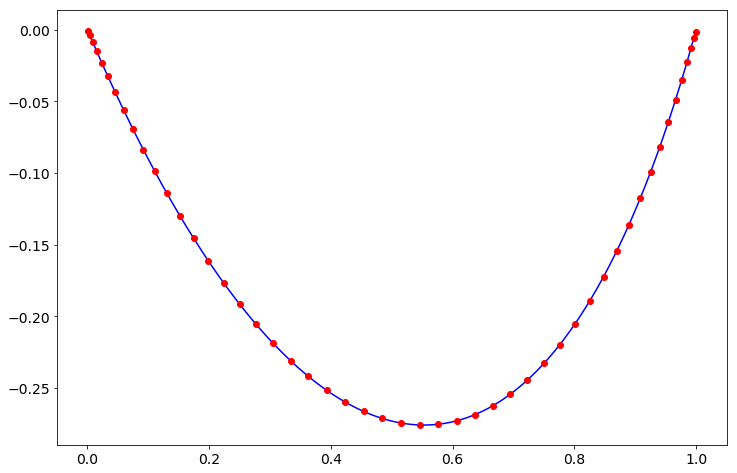

In [11]:
a, b = 0, 1
m = 50
us, xs = pstpbvp(a, b, p_func, q_func, r_func, m)
#us, xs = fd2tpbvp(a, b, 0, 0, p_func, q_func, r_func, m)

err = la.norm(us - exact(xs))/la.norm(exact(xs))
print('Error: %g' % err)


zs = np.linspace(a, b, 1000)

plt.figure(figsize=(12,8))
plt.plot(zs, exact(zs), 'b-')
plt.plot(xs, us, 'ro')
plt.show()

In [12]:
us[0]

-0.00094743657503072

In [13]:
num_ms = 6
ms = [2+5*(i+1) for i in range(num_ms)]
a, b = 0, 1


print([m-2 for m in ms])
errors = []
for m in ms:
    u, xs = pstpbvp(a, b, p_func, q_func, r_func, m)
    err = la.norm(u - exact(xs))/la.norm(exact(xs))
    errors.append(err)

#plt.plot(xs, u_all, 'bo')
#plt.plot(xs, exact(xs), 'r-')

[5, 10, 15, 20, 25, 30]


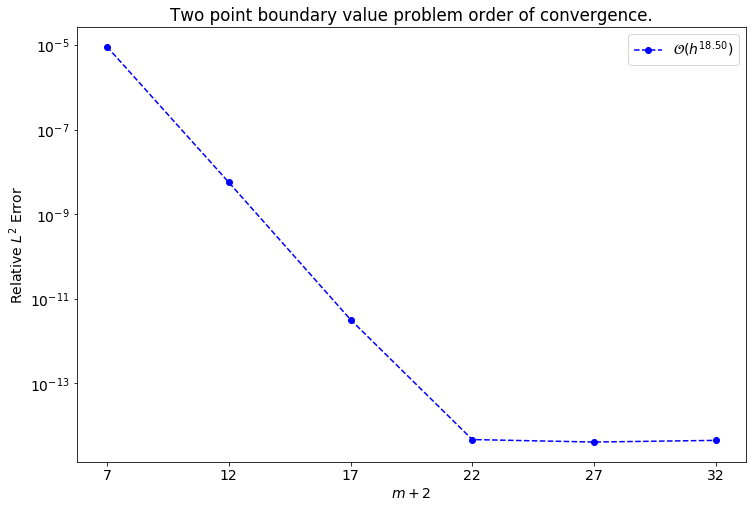

In [14]:
os, oe = 0, 4 #only include these in the order calculation
order = linreg(-np.log(ms[os:oe]), np.log(errors[os:oe]))[0]

plt.figure(figsize=(12,8))
plt.semilogy(ms, errors, 'bo--')
plt.legend(['$\mathcal{O}(h^{%.2f})$'%order])
plt.xticks(ms, ms)
plt.xlabel('$m+2$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Two point boundary value problem order of convergence.')
plt.show()

# Problem 4 (c)

In [133]:
part = 'd'
m = 99
a, b, = 0, 2*np.pi

if part == 'c':
    sa, sb = 0, 0
    def foo(x):
        return -4*np.cos(2*x)
    def u_true(x):
        return np.cos(2*x)
    plt_title = "DF2 Solution with Lagrange Multiplier \n$u'' = \\cos(2x)$    $u'(0)=0=u'(2\\pi)$"
elif part == 'd':
    sa, sb = -np.pi**2, np.pi**2
    def foo(x):
        return np.copy(x)
    def u_true(x):
        return 1/6* x**3 - np.pi**2*x + 2/3 * np.pi**3
    plt_title = "DF2 Solution with Lagrange Multiplier \n$u'' = x$    $u'(0)=-\\pi^2, \ u'(2\\pi) = \\pi^2$"
elif part == 'extra':
    sa, sb = 0, 0
    def foo(x):
        return np.copy(x)
    def u_true(x):
        return 1/6* x**3 - np.pi/2*x**2 + (np.pi**3/3)
    plt_title = "DF2 Best Solution with Lagrange Multiplier \n$u'' = x$    $u'(0)=0, \ u'(2\\pi) = 0$"

U = 0 #(sb-sa)/(b-a)


xs = np.linspace(a, b, m+2, endpoint=True)

h = (b-a)/(m+1)

A  = np.diag([-2.0]*(m+2))
A += np.diag([1]*(m+1), k=1)
A += np.diag([1]*(m+1), k=-1)
A[0,1] = 2
A[-1,-2] = 2
A *= h**-2



fs = foo(xs)
fs[0]  += 2/h * sa
fs[-1] -= 2/h * sb

w = np.ones(m+2)
w[0] = .5
w[-1] = .5

M = np.block([[A, w.reshape((m+2,1))],[w, 0]])

rhs = np.zeros(m+3)

rhs[:-1] = fs #foo(xs)

rhs[-1] = U*(m+1)

us = la.solve(M, rhs)
lam = us[-1]
us = us[:-1]

err = la.norm(us - u_true(xs))/la.norm(u_true(xs))


lambda = 9.71194e-15
error = 0.000183756


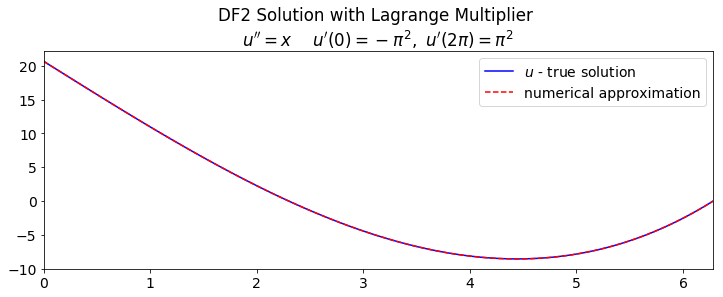

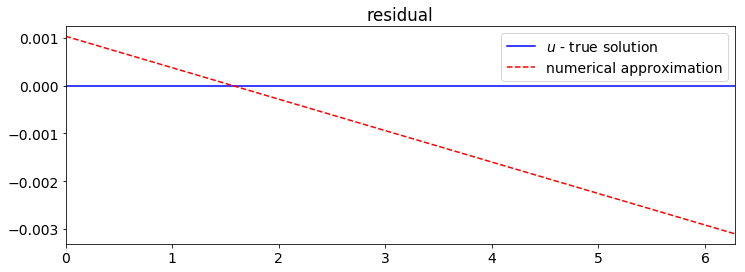

In [134]:
print('lambda = %g' %lam)
print('error = %g' % err)
legend = []

plt.figure(figsize=(12,4))
plt.plot(xs, u_true(xs), 'b-')
legend += ['$u$ - true solution']
plt.plot(xs, us, 'r--')
legend += ['numerical approximation']

plt.xlim(a, b)
plt.legend(legend)
plt.title(plt_title)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(xs, [0]*len(xs), 'b-')
plt.plot(xs, us-u_true(xs), 'r--')
plt.xlim(a, b)
plt.legend(legend)
plt.title('residual')
plt.show()

In [37]:
us_4 = us

This solution satisfies the homogeneous boundary conditions. When added to the solution to the homogeneous differential equation with our boundary conditions it yeilds the correct solution.

## Ignore this part

In [17]:
def foo(x):
    return np.copy(x)
    #return x*(2*np.pi-x)*(x-.5)

terms = 40
As = np.zeros(terms)
Bs = np.zeros(terms)
for i in range(0,terms):
    As[i] = quad(lambda x: np.cos(i*np.pi/(b-a)*x)*foo(x), a, b)[0]
for i in range(1,terms):
    Bs[i] = quad(lambda x: np.sin(i*np.pi/(b-a)*x)*foo(x), a, b)[0]
As[0] /= 2
As /= (b-a)
Bs /= (b-a)
    

def fourier(xs, As, Bs):
    n = len(As)
    mat = np.pi/(b-a) * np.multiply.outer(xs, np.arange(n))
    return np.cos(mat)@ As + np.sin(mat)@ Bs

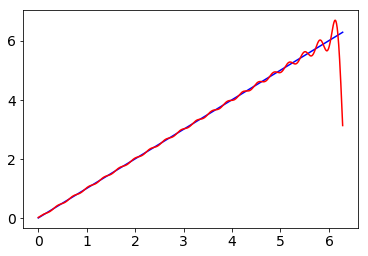

In [18]:
xs = np.linspace(0, 2*np.pi, 1000, endpoint=True)
plt.plot(xs, foo(xs), 'b-')
plt.plot(xs, fourier(xs, As, Bs), 'r-')

# Problem 5

In [125]:
sa, sb = 0, 0
def foo(x):
    return -4*np.cos(2*x)
def u_true(x):
    return np.cos(2*x)

In [126]:
m = 99
h = (b-a)/(m+1)
xs = np.linspace(a, b, m+2, endpoint=True)
fs = foo(xs)
fs[0]  += 2/h * sa
fs[-1] -= 2/h * sb

# fft.dct(xs, type=1)/2 ~ scipy needs to be scaled to match our form
# fft.idct(x_hat, type=1)/(n-1) ~ scipy needs to be scaled to match our form

f_hat = fft.dct(fs, type=1)/2
u_hat = np.zeros(len(xs))
u_hat[1:] = h**2 * f_hat[1:] / (2*np.cos(np.pi*np.arange(1,m+2)/(m+1)) - 2)
u_hat[0] = 0 # arbitrary
us = fft.idct(u_hat,type=1)/(m+1)

error = 0.00131699


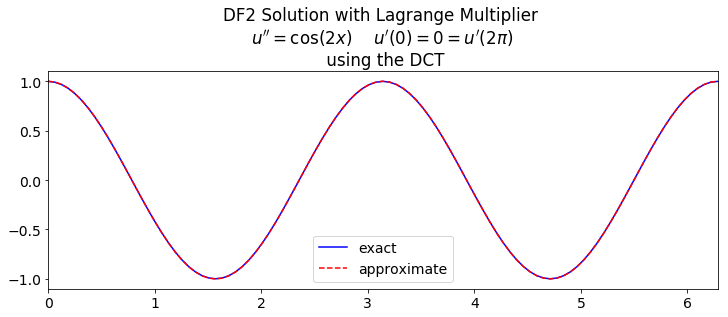

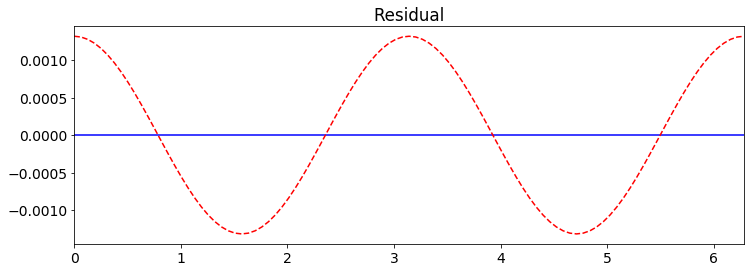

In [130]:
err = la.norm(us - u_true(xs))/la.norm(u_true(xs))
print('error = %g' % err)

legend = []
plt.figure(figsize=(12,4))
plt.plot(xs, u_true(xs), 'b-')
legend += ['exact']
plt.plot(xs, us, 'r--')
legend += ['approximate']
plt.xlim(a, b)
plt.legend(legend)
plt.title("DF2 Solution with Lagrange Multiplier \n$u'' = \\cos(2x)$    $u'(0)=0=u'(2\\pi)$ \n using the DCT")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(xs, [0]*len(xs), 'b-')
plt.plot(xs, us-u_true(xs), 'r--')
plt.xlim(a, b)
plt.title('Residual')
plt.show()

In [93]:
fft.dct(us-us_4, type=1)[:6]

array([-1.99876007e+00,  6.35788830e-13, -2.68387299e+00,  2.01557490e-13,
       -5.59835264e-01,  2.90462457e-14])

1.238431086642524e-12
1.0319597474423603e-13


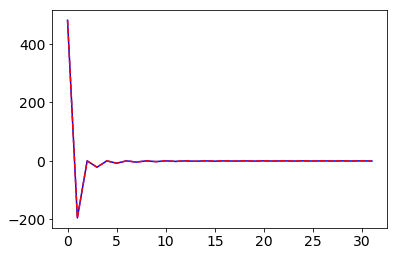

In [27]:
m = 30
cos_mat = np.cos( np.pi * np.multiply.outer(np.arange(m+2), np.arange(m+2)) / (m+1) )
cos_mat[:,[0,-1]] *= .5
x = np.arange(m+2)
print(la.norm( cos_mat @ x - fft.dct(x,type=1)/2))
print(la.norm( x - fft.idct(fft.dct(x,type=1)/2, type=1)/(m+1)))
plt.plot(x, cos_mat@x, 'b-')
plt.plot(x, fft.dct(x,type=1)/2, 'r--')

In [23]:
print(cos_mat)

[[ 0.5         1.          1.         ...  1.          1.
   0.5       ]
 [ 0.5         0.99486932  0.97952994 ... -0.97952994 -0.99486932
  -0.5       ]
 [ 0.5         0.97952994  0.91895781 ...  0.91895781  0.97952994
   0.5       ]
 ...
 [ 0.5        -0.97952994  0.91895781 ... -0.91895781  0.97952994
  -0.5       ]
 [ 0.5        -0.99486932  0.97952994 ...  0.97952994 -0.99486932
   0.5       ]
 [ 0.5        -1.          1.         ... -1.          1.
  -0.5       ]]


In [24]:
test = np.arange(9).reshape((3,3))
print(test)
test[[1,2], [2,1]] = [0, 0]
print(test)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 1 2]
 [3 4 0]
 [6 0 8]]


In [25]:
test

array([[0, 1, 2],
       [3, 4, 0],
       [6, 0, 8]])

In [26]:
A  = np.diag([-2.0]*(m+2))
A += np.diag([1]*(m+1), k=1)
A += np.diag([1]*(m+1), k=-1)
A[0,1] = 2
A[-1,-2] = 2
#A *= h**-2

w = np.ones(m+2)
w[0] = .5
w[-1] = .5

print(w.reshape((1,m+2)) @ A)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
